# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

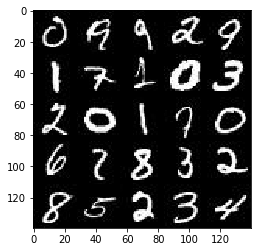

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

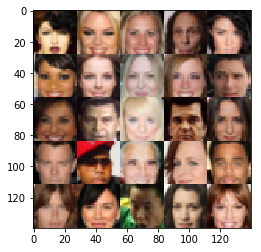

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None,z_dim],name='input_z')
    learningrate = tf.placeholder(tf.float32,name='learning_rate')

    return input_images, inputs_z, learningrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    keepprob=0.7
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        
        # Pad to 32x32x3 and then : Output 16x16x64
        dis1 = tf.pad(images,[[0,0],[2,2],[2,2],[0,0]],'CONSTANT')
        dis1 = tf.layers.conv2d(dis1, 64, 5, strides=2, padding='same', use_bias=False, activation=None)
        #dis1 = tf.layers.batch_normalization(dis1,training=True)
        dis1 = tf.maximum(alpha*dis1, dis1)
        #dis1 = tf.nn.dropout(dis1, keep_prob=keepprob)
        
        #Output 8x8x128
        dis2 = tf.layers.conv2d(dis1, 128, 5, strides=2, padding='same', use_bias=False, activation=None)
        dis2 = tf.layers.batch_normalization(dis2,training=True)
        dis2 = tf.maximum(alpha*dis2, dis2)
        #dis2 = tf.nn.dropout(dis2,keep_prob=keepprob)
        #Output 4x4x256
        dis3 = tf.layers.conv2d(dis2, 256, 5, strides=2, padding='same', use_bias=False, activation=None)
        dis3 = tf.layers.batch_normalization(dis3,training=True)
        dis3 = tf.maximum(alpha*dis3, dis3)
        dis3 = tf.nn.dropout(dis3,keep_prob=keepprob)

        # Logits and output
        
        x_out = tf.reshape(dis2,(-1, 4*4*256))
        logits = tf.layers.dense(x_out,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    keepprob=0.7
    #print(out_channel_dim)
    with tf.variable_scope('generator', reuse=not(is_train)):
  
        
        gen1 = tf.layers.dense(z,4*4*512)
        gen1 = tf.reshape(gen1, (-1, 4, 4, 512))
        
        
        #Output 4x4x512
        #gen2 = tf.layers.conv2d_transpose(gen1, 512, 5, strides=2, padding='same')
        gen2 = tf.layers.batch_normalization(gen1, training=is_train)
        gen2 = tf.maximum(alpha * gen2, gen2)
        #gen2 = tf.nn.dropout(gen2,keep_prob=keepprob)
        
        #Output 8x8x256
        gen3 = tf.layers.conv2d_transpose(gen2, 256, 5, strides=2, padding='same')
        gen3 = tf.layers.batch_normalization(gen3, training=is_train)
        gen3 = tf.maximum(alpha * gen3, gen3)
        #gen3 = tf.nn.dropout(gen3,keep_prob=keepprob)
        
        
        #Output 16x16x128
        gen4 = tf.layers.conv2d_transpose(gen3, 128, 5, strides=2, padding='same')
        gen4 = tf.layers.batch_normalization(gen4, training=is_train)
        gen4 = tf.maximum(alpha * gen4, gen4)
        gen4 = tf.nn.dropout(gen4,keep_prob=keepprob)
        
        
        #Output 28x28xout_channel_dim
        gen5 = tf.layers.conv2d_transpose(gen4, out_channel_dim, 5, strides=2, padding='same')
        _,split1,_= tf.split(gen5,[2,28,2],1) # Reduce width to 28
        _,logits,_ = tf.split(split1,[2,28,2],2) # Reduce height to 28
        out = tf.tanh(logits)
        
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #tf.reset_default_graph()
    show_every = 100
    steps=0
    losses=[]
    
    # Prelim calculations

    input_real, input_z , learningrate = model_inputs(data_shape[1], data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    #print('Done prelim')

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                #Rescale batch images
                batch_images*=2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #print('Done init')
                
                # Run optimizers
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningrate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learningrate:learning_rate})
                
                #print('Run optimizers')
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 36, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

[<tf.Tensor 'gradients_1/generator/split_1_grad/concat:0' shape=(?, 28, 32, 1) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/generator/split_grad/concat:0' shape=(?, 32, 32, 1) dtype=float32>, None, None]
Epoch 1/2... Discriminator Loss: 2.6054... Generator Loss: 0.1310
Epoch 1/2... Discriminator Loss: 1.6856... Generator Loss: 0.3501
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.5281
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 0.9925
Epoch 1/2... Discriminator Loss: 0.9745... Generator Loss: 1.2212
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 1.3528
Epoch 1/2... Discriminator Loss: 0.8069... Generator Loss: 1.4693
Epoch 1/2... Discriminator Loss: 1.5141... Generator Loss: 0.7715


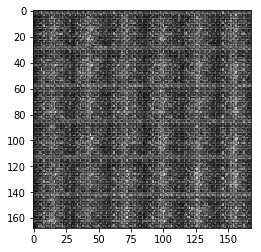

Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.8622
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 0.9881
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 0.9617... Generator Loss: 1.1888
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.9374


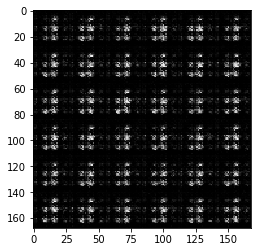

Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 1.1144
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 1.0173
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 0.9186... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 1.1579
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 1.3384
Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 1.0338
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 1.0025


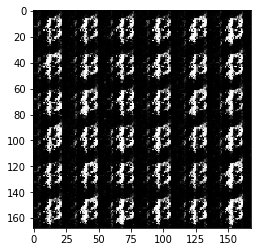

Epoch 1/2... Discriminator Loss: 1.1572... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.1858
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.0132
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.9440
Epoch 1/2... Discriminator Loss: 1.1291... Generator Loss: 1.0549
Epoch 1/2... Discriminator Loss: 1.0752... Generator Loss: 1.0978


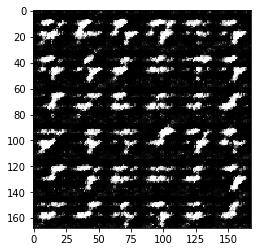

Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.9431
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.9939
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.0861
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.9022


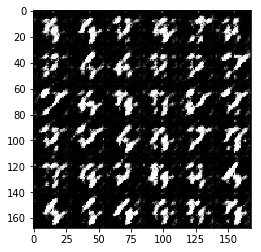

Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.9986
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.9188
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.9274


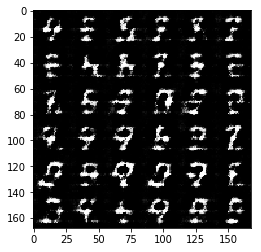

Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.9565
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.9957
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.0572


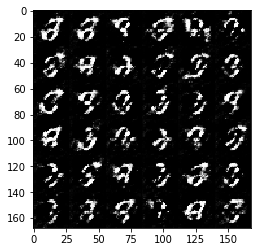

Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.1291... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.8814
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.8654
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.9060
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.9368


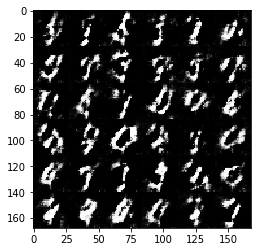

Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.9433
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.9153


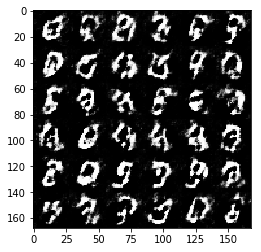

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8589
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.9490
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.8217


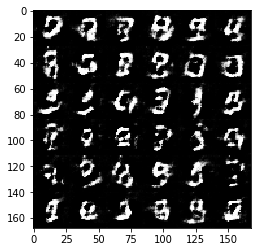

Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 1.0229
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.9310


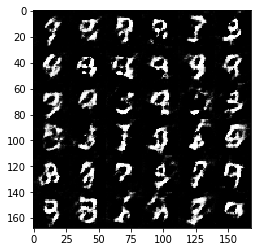

Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.9160
Epoch 2/2... Discriminator Loss: 1.1744... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.9063
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 1.2011... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.9086


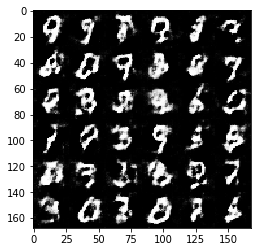

Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.8975
Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.9832
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.8583
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.8603


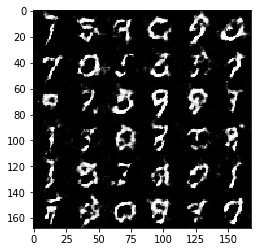

Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.9036
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.8603
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.9352
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.9933


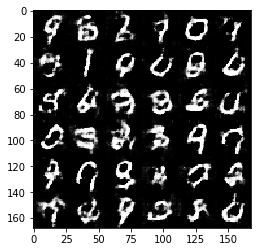

Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.9783
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.8327


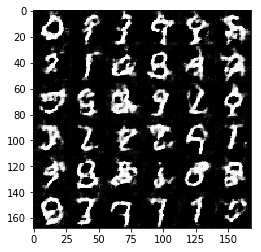

Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.9326
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.2790... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.2915... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.9549


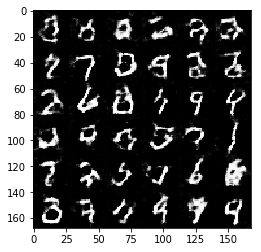

Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.9423
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.8139
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 1.0733
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.8524


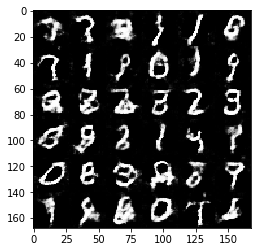

Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.8978
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.9154
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.9904
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 1.0246
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.8145


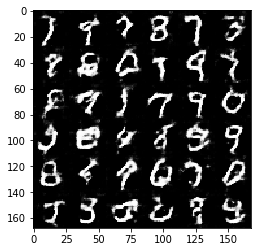

Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.9603
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.7545


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

[<tf.Tensor 'gradients_1/generator/split_1_grad/concat:0' shape=(?, 28, 32, 3) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/generator/split_grad/concat:0' shape=(?, 32, 32, 3) dtype=float32>, None, None]
Epoch 1/1... Discriminator Loss: 3.0928... Generator Loss: 0.0870
Epoch 1/1... Discriminator Loss: 2.5495... Generator Loss: 0.1695
Epoch 1/1... Discriminator Loss: 2.2245... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 2.0652... Generator Loss: 0.3346
Epoch 1/1... Discriminator Loss: 1.9156... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.6518... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8287


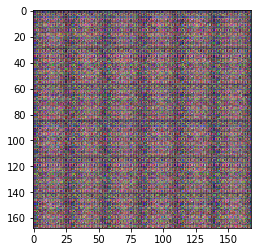

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.7357... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.0266


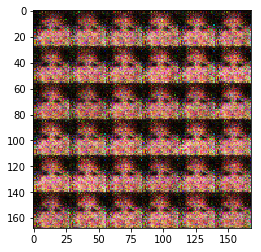

Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.3096


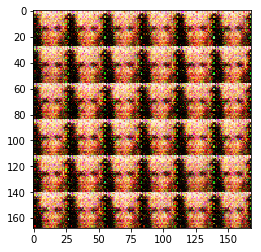

Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.3855


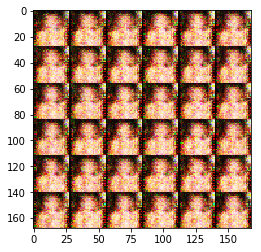

Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.4824
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.4155
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.2516


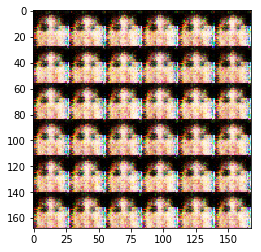

Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.4414
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.5520
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.4079
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.5297
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.2027


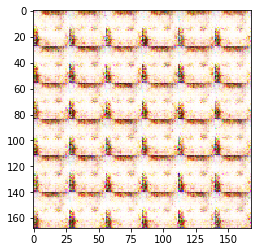

Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.4648
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.5359
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.3520


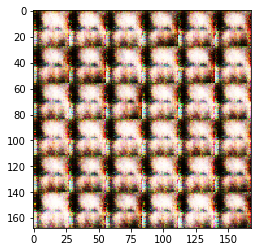

Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.1130


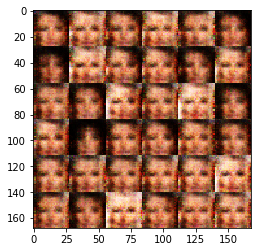

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.0624


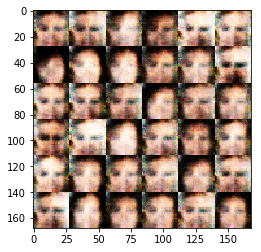

Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.0353


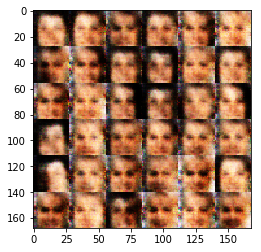

Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9686


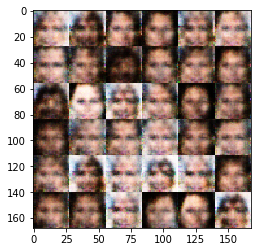

Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.9894


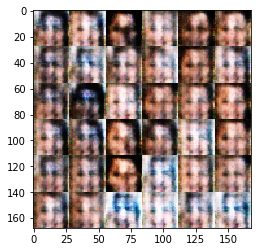

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8099


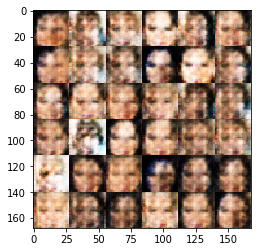

Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.0437


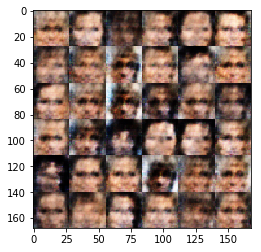

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.9059


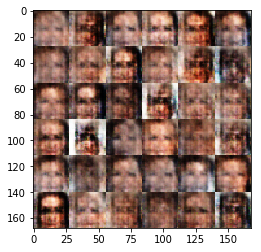

Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8044


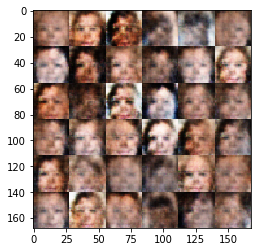

Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7939


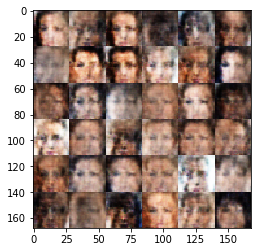

Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7210


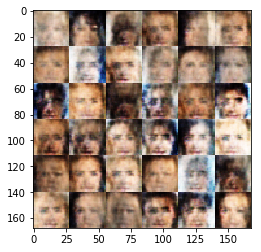

Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.7178


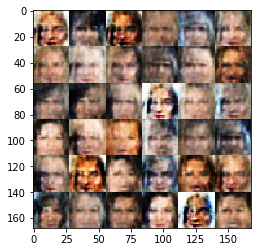

Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8003


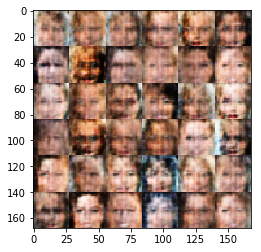

Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7230


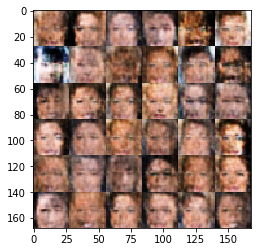

Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7415


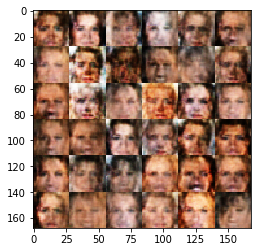

Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8059


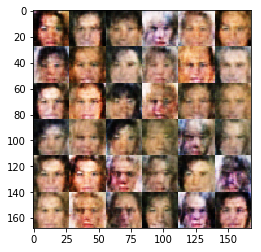

Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7050


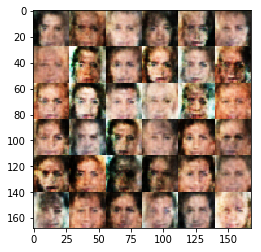

Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7904


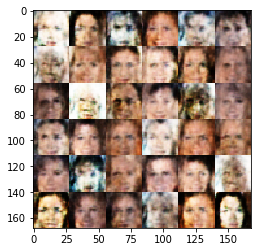

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7294


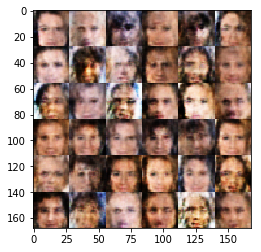

Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7803


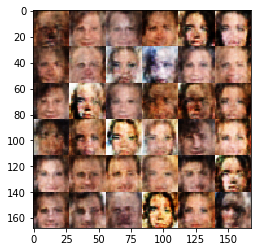

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8030


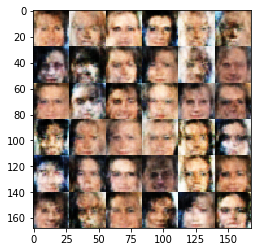

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8031


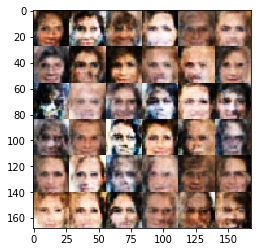

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7717


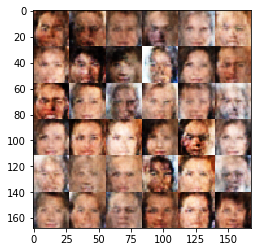

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7615


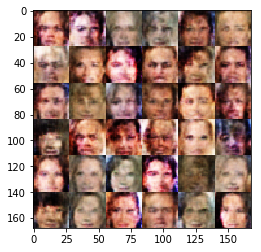

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7882


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.